 # Privileged Attribution Constrained Deep Networks for Facial Expression Recognition

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

## Download RAF-DB dataset (Google Colab)

In [4]:
! wget https://github.com/MegaloPat/DNN/raw/main/DNN/aligned.zip

--2023-01-30 13:58:38--  https://github.com/MegaloPat/DNN/raw/main/DNN/aligned.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MegaloPat/DNN/main/DNN/aligned.zip [following]
--2023-01-30 13:58:38--  https://raw.githubusercontent.com/MegaloPat/DNN/main/DNN/aligned.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39152089 (37M) [application/zip]
Saving to: ‘aligned.zip’

aligned.zip         100%[===================>]  37.34M   186MB/s    in 0.2s    

2023-01-30 13:58:39 (186 MB/s) - ‘aligned.zip’ saved [39152089/39152089]



In [5]:
! wget https://github.com/MegaloPat/DNN/raw/main/DNN/landmark.zip

--2023-01-30 13:58:40--  https://github.com/MegaloPat/DNN/raw/main/DNN/landmark.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MegaloPat/DNN/main/DNN/landmark.zip [following]
--2023-01-30 13:58:40--  https://raw.githubusercontent.com/MegaloPat/DNN/main/DNN/landmark.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86475976 (82M) [application/zip]
Saving to: ‘landmark.zip’

landmark.zip        100%[===================>]  82.47M   209MB/s    in 0.4s    

2023-01-30 13:58:41 (209 MB/s) - ‘landmark.zip’ saved [86475976/86475976]



In [6]:
! wget https://raw.githubusercontent.com/MegaloPat/DNN/main/DNN/list_patition_label.txt

--2023-01-30 13:58:42--  https://raw.githubusercontent.com/MegaloPat/DNN/main/DNN/list_patition_label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285305 (279K) [text/plain]
Saving to: ‘list_patition_label.txt’

list_patition_label 100%[===================>] 278.62K  --.-KB/s    in 0.04s   

2023-01-30 13:58:42 (7.72 MB/s) - ‘list_patition_label.txt’ saved [285305/285305]



## Download pretrained VGG_Face weights (Google Colab)

In [7]:
! wget https://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth

--2023-01-30 13:58:45--  https://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580015466 (553M)
Saving to: ‘vgg_face_dag.pth’

vgg_face_dag.pth    100%[===================>] 553.15M  28.9MB/s    in 20s     

2023-01-30 13:59:05 (27.9 MB/s) - ‘vgg_face_dag.pth’ saved [580015466/580015466]



# I - Vanilla classification with pretrained VGG

First we will try to get baseline results with VGG pretrained on VGG_Face without any changes.

## Prepare dataset

### Unzip data

In [8]:
import zipfile

with zipfile.ZipFile("aligned.zip", 'r') as zip_ref:
    zip_ref.extractall("./aligned")

In [9]:
!mkdir aligned/train
!mkdir aligned/test
!mv aligned/aligned/train_* aligned/train
!mv aligned/aligned/test_* aligned/test

### Prepare csv labels

In [10]:
import csv

with open("list_patition_label.txt","r") as file :
    train_csv = open("train_list_label.csv","w",newline="")
    test_csv = open("test_list_label.csv","w",newline="")

    train_writer = csv.writer(train_csv)
    train_writer.writerow(["Filename", "Label"])
    
    test_writer = csv.writer(test_csv)
    test_writer.writerow(["Filename", "Label"])
    
    
    for line in file:
        filename, label = line.strip().split(" ")
        idx = filename.index(".jpg")
        filename = filename[:idx] + "_aligned" + filename[idx:]
        label = str(int(label) - 1)
        
        if "train" in filename :
            train_writer.writerow([filename, label])
        else :
            test_writer.writerow([filename, label])


### Preprocessing transform
Preprocessing is the same as the experimental protocol of the original paper. This includes :
* Resize to 224x224
* Random rotation of -10° +10°
* Random horizontal flip

In [11]:
trans = transforms.Compose([
    transforms.Lambda(lambda x: x.float()),
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip()
])

### Create dataloaders
Validation set will be sampled with a stratified split of test set, as in the paper, with ratio 50/50.

Overall the proportions for the train/test/validation datasets are 80/10/10 %

Finally, we will use a batch size of 16 as in the paper.

In [12]:
import pandas as pd
import os
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [13]:
train_data = CustomImageDataset("train_list_label.csv","./aligned/train", transform=trans)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in train: {len(train_loader)}")


Nb batches in train: 758


In [14]:
from sklearn.model_selection import train_test_split
test_data = CustomImageDataset("test_list_label.csv","./aligned/test", transform=trans)

test_indices, val_indices = train_test_split(list(range(len(test_data.img_labels.Label))), test_size=0.5, stratify=test_data.img_labels.Label)

val_data = torch.utils.data.Subset(test_data, val_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)


In [15]:
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in test: {len(test_loader)}")


Nb batches in test: 92


In [16]:
val_loader = DataLoader(val_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in val: {len(val_loader)}")


Nb batches in val: 92


## VGG class

In [17]:

import torch
import torch.nn as nn


class Vgg(nn.Module):

    def __init__(self):
        super(Vgg, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)


    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        return x38

def vgg_face(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg()
    if weights_path:
        state_dict = torch.load(weights_path)
        state_dict.pop("fc6.weight")
        state_dict.pop("fc6.bias")
        state_dict.pop("fc7.weight")
        state_dict.pop("fc7.bias")
        state_dict.pop("fc8.weight")
        state_dict.pop("fc8.bias")
        model.load_state_dict(state_dict, strict=False)
    return model

### Load pretrained weights on vgg_face

In [18]:
vgg = vgg_face("vgg_face_dag.pth")
vgg = vgg.to(device)

## Train

### Initial evaluation on validation dataset

In [19]:
cross_entropy = nn.CrossEntropyLoss()

def eval_model(net, loader):
  net.eval()
  acc, loss = 0., 0.
  c = 0
  for x, y in loader:
    with torch.no_grad():
      # No need to compute gradient here thus we avoid storing intermediary activations
      logits = net(x.to(device)).cpu()

    loss += cross_entropy(logits, y).item()
    preds = logits.argmax(dim=1)
    acc += (preds.numpy() == y.numpy()).sum()
    c += len(x)

  acc /= c
  loss /= len(loader)
  net.train()
  return acc, loss

In [ ]:
initial_acc, initial_loss = eval_model(vgg, val_loader)
print(f"Initial accuracy/loss on val: {round(100 * initial_acc, 2)}/{round(initial_loss, 4)}")

Initial accuracy/loss on val: 9.17/2.7371


### Training

Training will be performed with adam optimizer, using a base learning rate of 5e-5 and polynomial decay on all epochs with a power of 0.5, for 75 epochs.  
We will save the best model according to the accuracy on the validation set.  
These parameters follow the experimental protocol of the paper.

In [20]:
from torch.optim.lr_scheduler import PolynomialLR


optimizer = torch.optim.Adam(vgg.parameters(), lr=0.00005)
scheduler = PolynomialLR(optimizer, total_iters=75, power=2)

nb_epochs = 75

train_accs, train_losses = [], []
val_accs, val_losses = [], []

In [ ]:
from tqdm import tqdm
best_acc = 0
for epoch in range(nb_epochs):
  with tqdm(train_loader, unit="batch") as tepoch:
    start = time.time()
    running_acc, running_loss = 0., 0.
    c = 0
    for x, y in tepoch:
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()  # Clear previous gradients
      logits = vgg(x)
      loss = cross_entropy(logits, y)
      loss.backward()  # Compute gradients
      optimizer.step()  # Update weights with gradients

      running_acc += (logits.argmax(dim=1).cpu().numpy() == y.cpu().numpy()).sum()
      running_loss += loss.item()
      c += len(x)
      tepoch.set_postfix(loss=loss.item())
    
    scheduler.step()
    train_acc, train_loss = running_acc / c, running_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    val_acc, val_loss = eval_model(vgg, val_loader)
    if val_acc > best_acc:
      best_acc = val_acc
      torch.save(vgg.state_dict(),"vgg_best_param.pth")
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch + 1}/{nb_epochs}, "
        f"train acc/loss: {round(100 * train_acc, 2)}/{round(train_loss, 4)}, "
        f"val acc/loss: {round(100 * val_acc, 2)}/{round(val_loss, 4)}, "
        f"time {int(time.time() - start)}s"
    )

100%|██████████| 758/758 [03:42<00:00,  3.40batch/s, loss=0.705]


Epoch 1/75, train acc/loss: 64.09/1.0287, val acc/loss: 76.63/0.725, time 233s


100%|██████████| 758/758 [03:41<00:00,  3.43batch/s, loss=0.268]


Epoch 2/75, train acc/loss: 77.72/0.656, val acc/loss: 81.11/0.5792, time 231s


100%|██████████| 758/758 [03:41<00:00,  3.43batch/s, loss=0.0805]


Epoch 3/75, train acc/loss: 82.55/0.5245, val acc/loss: 80.1/0.5996, time 229s


100%|██████████| 758/758 [03:40<00:00,  3.43batch/s, loss=0.455]


Epoch 4/75, train acc/loss: 85.63/0.4317, val acc/loss: 80.43/0.578, time 229s


100%|██████████| 758/758 [03:40<00:00,  3.43batch/s, loss=0.528]


Epoch 5/75, train acc/loss: 87.9/0.3652, val acc/loss: 82.0/0.5502, time 231s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=0.115]


Epoch 6/75, train acc/loss: 89.61/0.3015, val acc/loss: 84.38/0.5419, time 230s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=0.033]


Epoch 7/75, train acc/loss: 91.42/0.2534, val acc/loss: 82.74/0.7013, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.278]


Epoch 8/75, train acc/loss: 93.19/0.2085, val acc/loss: 83.9/0.5869, time 228s


100%|██████████| 758/758 [03:40<00:00,  3.45batch/s, loss=0.293]


Epoch 9/75, train acc/loss: 93.84/0.1837, val acc/loss: 83.49/0.6098, time 228s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=0.166]


Epoch 10/75, train acc/loss: 95.12/0.1491, val acc/loss: 83.29/0.6642, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.023]


Epoch 11/75, train acc/loss: 95.56/0.138, val acc/loss: 84.17/0.578, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.0125]


Epoch 12/75, train acc/loss: 96.5/0.1115, val acc/loss: 84.92/0.6096, time 230s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.0981]


Epoch 13/75, train acc/loss: 96.72/0.0981, val acc/loss: 83.56/0.7355, time 228s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=0.0004]


Epoch 14/75, train acc/loss: 96.94/0.096, val acc/loss: 84.04/0.7467, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.122]


Epoch 15/75, train acc/loss: 97.1/0.0831, val acc/loss: 84.17/0.7017, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.216]


Epoch 16/75, train acc/loss: 97.59/0.0712, val acc/loss: 83.9/0.7717, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.00282]


Epoch 17/75, train acc/loss: 98.06/0.0606, val acc/loss: 83.49/0.9617, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.00188]


Epoch 18/75, train acc/loss: 97.76/0.0655, val acc/loss: 84.1/0.7226, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.535]


Epoch 19/75, train acc/loss: 98.05/0.0565, val acc/loss: 84.71/0.7631, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.277]


Epoch 20/75, train acc/loss: 98.39/0.047, val acc/loss: 84.85/0.7385, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.0231]


Epoch 21/75, train acc/loss: 98.38/0.0504, val acc/loss: 83.76/0.8841, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=5.78e-5]


Epoch 22/75, train acc/loss: 98.85/0.0375, val acc/loss: 84.38/0.9789, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.0204]


Epoch 23/75, train acc/loss: 98.89/0.0354, val acc/loss: 83.7/0.9775, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.00355]


Epoch 24/75, train acc/loss: 98.89/0.0367, val acc/loss: 83.02/0.9421, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.00327]


Epoch 25/75, train acc/loss: 98.84/0.0352, val acc/loss: 85.19/0.8589, time 230s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.000695]


Epoch 26/75, train acc/loss: 99.03/0.0314, val acc/loss: 84.71/0.8724, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.00117]


Epoch 27/75, train acc/loss: 99.17/0.026, val acc/loss: 85.19/0.9102, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.000238]


Epoch 28/75, train acc/loss: 99.22/0.0249, val acc/loss: 84.65/0.9603, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.147]


Epoch 29/75, train acc/loss: 99.17/0.0252, val acc/loss: 85.53/0.8378, time 230s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.00015]


Epoch 30/75, train acc/loss: 99.42/0.0167, val acc/loss: 85.6/1.2101, time 230s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.00329]


Epoch 31/75, train acc/loss: 99.24/0.0251, val acc/loss: 85.53/0.9538, time 228s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=0.0695]


Epoch 32/75, train acc/loss: 99.55/0.018, val acc/loss: 86.35/0.9351, time 231s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=5.11e-8]


Epoch 33/75, train acc/loss: 99.47/0.0161, val acc/loss: 85.6/1.0324, time 228s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=0.000174]


Epoch 34/75, train acc/loss: 99.6/0.0129, val acc/loss: 85.05/1.3262, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.000133]


Epoch 35/75, train acc/loss: 99.5/0.0181, val acc/loss: 84.65/0.9949, time 228s


100%|██████████| 758/758 [03:40<00:00,  3.45batch/s, loss=4.77e-6]


Epoch 36/75, train acc/loss: 99.51/0.0131, val acc/loss: 84.85/1.2436, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=8.85e-5]


Epoch 37/75, train acc/loss: 99.63/0.0106, val acc/loss: 83.7/1.1518, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=3.24e-7]


Epoch 38/75, train acc/loss: 99.74/0.0087, val acc/loss: 85.05/1.2651, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=4.68e-5]


Epoch 39/75, train acc/loss: 99.73/0.0114, val acc/loss: 84.99/1.1603, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=1.12e-6]


Epoch 40/75, train acc/loss: 99.73/0.0077, val acc/loss: 84.24/1.4317, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0]


Epoch 41/75, train acc/loss: 99.88/0.0034, val acc/loss: 85.73/1.4012, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=1.88e-5]


Epoch 42/75, train acc/loss: 99.71/0.0092, val acc/loss: 84.78/1.3046, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=1.28e-6]


Epoch 43/75, train acc/loss: 99.82/0.0058, val acc/loss: 86.28/1.3636, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0]


Epoch 44/75, train acc/loss: 99.89/0.0042, val acc/loss: 85.94/1.2653, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=2.04e-7]


Epoch 45/75, train acc/loss: 99.85/0.0053, val acc/loss: 86.14/1.2679, time 228s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=3.58e-7]


Epoch 46/75, train acc/loss: 99.93/0.002, val acc/loss: 85.12/1.4346, time 228s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=0.000147]


Epoch 47/75, train acc/loss: 99.86/0.0037, val acc/loss: 86.28/1.3983, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=1.53e-6]


Epoch 48/75, train acc/loss: 99.88/0.0038, val acc/loss: 84.71/1.1672, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=7.65e-6]


Epoch 49/75, train acc/loss: 99.91/0.0034, val acc/loss: 85.46/1.4465, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0]


Epoch 50/75, train acc/loss: 99.92/0.0031, val acc/loss: 86.28/1.2651, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=3.41e-8]


Epoch 51/75, train acc/loss: 99.92/0.0023, val acc/loss: 85.53/1.4017, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0]


Epoch 52/75, train acc/loss: 99.98/0.002, val acc/loss: 85.19/1.3144, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=5.11e-8]


Epoch 53/75, train acc/loss: 99.99/0.0003, val acc/loss: 87.02/1.3367, time 230s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=2.38e-7]


Epoch 54/75, train acc/loss: 99.94/0.0024, val acc/loss: 86.35/1.4411, time 228s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=0]


Epoch 55/75, train acc/loss: 99.99/0.0004, val acc/loss: 85.94/1.4771, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0]


Epoch 56/75, train acc/loss: 99.99/0.0006, val acc/loss: 86.41/1.4861, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0]


Epoch 57/75, train acc/loss: 99.98/0.0015, val acc/loss: 86.28/1.4328, time 228s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=9.48e-5]


Epoch 58/75, train acc/loss: 100.0/0.0002, val acc/loss: 86.41/1.4642, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=5.64e-6]


Epoch 59/75, train acc/loss: 99.98/0.0004, val acc/loss: 86.62/1.411, time 228s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=1.7e-8]


Epoch 60/75, train acc/loss: 100.0/0.0001, val acc/loss: 86.01/1.5445, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=2.55e-7]


Epoch 61/75, train acc/loss: 100.0/0.0001, val acc/loss: 85.8/1.5086, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0.00112]


Epoch 62/75, train acc/loss: 99.99/0.0003, val acc/loss: 85.6/1.6099, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.46batch/s, loss=3.41e-8]


Epoch 63/75, train acc/loss: 100.0/0.0002, val acc/loss: 86.82/1.5996, time 227s


100%|██████████| 758/758 [03:40<00:00,  3.43batch/s, loss=3.41e-8]


Epoch 64/75, train acc/loss: 100.0/0.0001, val acc/loss: 86.68/1.5429, time 229s


100%|██████████| 758/758 [03:41<00:00,  3.42batch/s, loss=0.000274]


Epoch 65/75, train acc/loss: 99.99/0.0003, val acc/loss: 87.43/1.4893, time 232s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=0]


Epoch 66/75, train acc/loss: 100.0/0.0001, val acc/loss: 86.35/1.6264, time 229s


100%|██████████| 758/758 [03:40<00:00,  3.44batch/s, loss=3.27e-5]


Epoch 67/75, train acc/loss: 100.0/0.0, val acc/loss: 85.8/1.6941, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0]


Epoch 68/75, train acc/loss: 100.0/0.0001, val acc/loss: 86.41/1.6295, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0]


Epoch 69/75, train acc/loss: 100.0/0.0, val acc/loss: 86.62/1.5891, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=1.02e-7]


Epoch 70/75, train acc/loss: 99.99/0.0002, val acc/loss: 86.41/1.6142, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0]


Epoch 71/75, train acc/loss: 100.0/0.0, val acc/loss: 85.94/1.7246, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0]


Epoch 72/75, train acc/loss: 100.0/0.0, val acc/loss: 87.23/1.5663, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=0]


Epoch 73/75, train acc/loss: 99.99/0.0002, val acc/loss: 86.01/1.6288, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=1.07e-6]


Epoch 74/75, train acc/loss: 100.0/0.0, val acc/loss: 86.89/1.5909, time 228s


100%|██████████| 758/758 [03:39<00:00,  3.45batch/s, loss=1.7e-8]


Epoch 75/75, train acc/loss: 99.99/0.0007, val acc/loss: 86.28/1.609, time 228s


Text(0.5, 1.0, 'Loss')

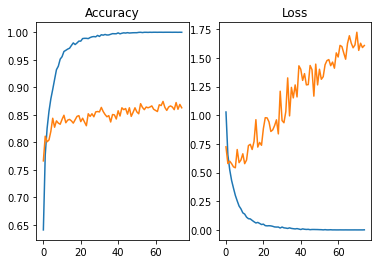

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(list(range(nb_epochs)), train_accs, label="Train")
plt.plot(list(range(nb_epochs)), val_accs, label="Val")
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(list(range(nb_epochs)), train_losses, label="Train")
plt.plot(list(range(nb_epochs)), val_losses, label="Val")
plt.title("Loss")

### Testing

In [ ]:
state_dict = torch.load("vgg_best_param.pth")
vgg.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
test_acc, test_loss = eval_model(vgg, test_loader)
test_acc, test_loss

(0.8640380693405847, 1.3545154936775519)

# II - Vgg with Pal


Now we will train to reproduce the best results of the paper using PAL. Consequently, we will use PAL on the 15th layer, with Grad\*Input as attribution map and the half mean channel strategy. The other parameters will follow the paper, and thus will not change compared to part 1.

## Prepare dataset

### Unzip priors

In [21]:
import zipfile
with zipfile.ZipFile("landmark.zip", 'r') as zip_ref:
    zip_ref.extractall("./landmark")

In [22]:
!mkdir landmark/train
!mkdir landmark/test
!mv landmark/landmark/train_* landmark/train
!mv landmark/landmark/test_* landmark/test

### Create dataloaders
The process is the same as in part I, with the added priors.

In [23]:
class JoinImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, landmark_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.landmark_dir = landmark_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        land_path = os.path.join(self.landmark_dir, self.img_labels.iloc[idx, 0])
        landmark = read_image(land_path)
        landmark = landmark / 255.0
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, landmark, label

In [24]:
train_data = JoinImageDataset("train_list_label.csv","./aligned/train", "./landmark/train", transform=trans)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in train: {len(train_loader)}")


Nb batches in train: 758


In [25]:
from sklearn.model_selection import train_test_split
test_data = JoinImageDataset("test_list_label.csv","./aligned/test","./landmark/test", transform=trans)

test_indices, val_indices = train_test_split(list(range(len(test_data.img_labels.Label))), test_size=0.5, stratify=test_data.img_labels.Label)

val_data = torch.utils.data.Subset(test_data, val_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)

In [26]:
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in test: {len(test_loader)}")


Nb batches in test: 92


In [27]:
val_loader = DataLoader(val_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in val: {len(val_loader)}")


Nb batches in val: 92


## Modified Vgg class
The class now outputs the features computed by layer 15 as well in order to apply PAL.

In [28]:
import torch
import torch.nn as nn


class VggPal(Vgg):

    def __init__(self):
        super(VggPal, self).__init__()
  
    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        
        return x25,x38

def vggpal_face(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = VggPal()
    if weights_path:
        state_dict = torch.load(weights_path)
        state_dict.pop("fc6.weight")
        state_dict.pop("fc6.bias")
        state_dict.pop("fc7.weight")
        state_dict.pop("fc7.bias")
        state_dict.pop("fc8.weight")
        state_dict.pop("fc8.bias")
        model.load_state_dict(state_dict, strict=False)
    return model

### Load pretrained weights on vgg_face

In [29]:
vggpal = vggpal_face("vgg_face_dag.pth")
vggpal = vggpal.to(device)

## Definition of PAL

In [30]:
def Grad(features, logits) :
    logits_sum = logits.sum()
    features.retain_grad()
    logits_sum.backward(retain_graph=True)
    return torch.abs(features.grad)

def GradxInput(features, logits) :
    Grad_val = Grad(features, logits)
    return Grad_val * features

def PAL(features, logits, prior, attribution_method, channel_strategy=None) :
    attribution_map = attribution_method(features, logits)
    
    if channel_strategy == "half_mean" :
        nb_class = attribution_map.shape[1]
        attribution_map = attribution_map[:, int(nb_class/2):, :, :]
    
    if channel_strategy == "half_mean" or channel_strategy == "mean" :
        attribution_map = attribution_map.mean(1).unsqueeze(1)
    
    attribution_map_resize = transforms.Resize(attribution_map.shape[-2:])
    
    prior = attribution_map_resize(prior)
    
    std = attribution_map.view(attribution_map.size(0), -1).std(1)
    mean = attribution_map.view(attribution_map.size(0), -1).mean(1)
    
    
    res = (attribution_map - mean.view(-1, 1, 1, 1)) / (std.view(-1, 1, 1, 1) + 1e-9)
    res = res * prior.unsqueeze(1)
    
    res = res.view(res.size(0), -1).sum(1)
    res = -res
    return res.mean()

In [31]:
def tot_loss(features, prior, logits, y):
    pa_loss = PAL(features, logits, prior, GradxInput, "half_mean")
    ce_loss = cross_entropy(logits, y)
    return pa_loss + ce_loss

## Train

### Initial evaluation on validation dataset

In [32]:
def eval_modelpal(net, loader):
  net.eval()
  acc, loss = 0., 0.
  c = 0
  for x, prior, y in loader:
    x, prior, y = x.to(device), prior.to(device),y.to(device)
    features, logits = net(x.to(device))
    loss += tot_loss(features, prior, logits, y).item()
    preds = logits.argmax(dim=1)
    acc += (preds.cpu().numpy() == y.cpu().numpy()).sum()
    c += len(x)

  acc /= c
  loss /= len(loader)
  net.train()
  return acc, loss

In [33]:
initial_acc, initial_loss = eval_modelpal(vggpal, val_loader)
print(f"Initial accuracy/loss on val: {round(100 * initial_acc, 2)}/{round(initial_loss, 4)}")

Initial accuracy/loss on val: 14.74/1.7506


### Training

In [34]:
optimizer = torch.optim.Adam(vggpal.parameters(), lr=0.00005)
scheduler = PolynomialLR(optimizer, total_iters=75, power=2)

nb_epochs = 75

train_accs, train_losses = [], []
val_accs, val_losses = [], []

In [35]:
from tqdm import tqdm
best_acc = 0
for epoch in range(nb_epochs):
  with tqdm(train_loader, unit="batch") as tepoch:
    start = time.time()
    running_acc, running_loss = 0., 0.
    c = 0
    for x, prior, y in tepoch:
      x, prior, y = x.to(device), prior.to(device),y.to(device)

      optimizer.zero_grad()  # Clear previous gradients
      features, logits = vggpal(x)
      loss = tot_loss(features, prior, logits, y)
      vggpal.zero_grad() # Remove gradients of PAL
      loss.backward()  # Compute gradients
      optimizer.step()  # Update weights with gradients

      running_acc += (logits.argmax(dim=1).cpu().numpy() == y.cpu().numpy()).sum()
      running_loss += loss.item()
      c += len(x)
      tepoch.set_postfix(loss=loss.item())
    
    scheduler.step()

    train_acc, train_loss = running_acc / c, running_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    val_acc, val_loss = eval_modelpal(vggpal, val_loader)
    if val_acc > best_acc:
      best_acc = val_acc
      torch.save(vggpal.state_dict(),"vggpal_best_param.pth")
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch + 1}/{nb_epochs}, "
        f"train acc/loss: {round(100 * train_acc, 2)}/{round(train_loss, 4)}, "
        f"val acc/loss: {round(100 * val_acc, 2)}/{round(val_loss, 4)}, "
        f"time {int(time.time() - start)}s"
    )

100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-638]


Epoch 1/75, train acc/loss: 60.52/-1377.5174, val acc/loss: 69.23/-1467.2321, time 58s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-692]


Epoch 2/75, train acc/loss: 69.29/-1494.0894, val acc/loss: 68.95/-1489.5812, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-638]


Epoch 3/75, train acc/loss: 72.38/-1503.8771, val acc/loss: 75.34/-1494.6584, time 59s


100%|██████████| 758/758 [00:54<00:00, 14.03batch/s, loss=-608]


Epoch 4/75, train acc/loss: 73.57/-1503.5836, val acc/loss: 78.8/-1497.7335, time 60s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-616]


Epoch 5/75, train acc/loss: 75.69/-1505.5986, val acc/loss: 79.28/-1478.3336, time 59s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-597]


Epoch 6/75, train acc/loss: 76.81/-1505.7509, val acc/loss: 78.6/-1468.3243, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-727]


Epoch 7/75, train acc/loss: 77.98/-1497.2773, val acc/loss: 79.55/-1495.6136, time 59s


100%|██████████| 758/758 [00:54<00:00, 14.03batch/s, loss=-674]


Epoch 8/75, train acc/loss: 78.04/-1499.6649, val acc/loss: 78.53/-1493.42, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.03batch/s, loss=-612]


Epoch 9/75, train acc/loss: 79.58/-1497.5405, val acc/loss: 79.14/-1479.5565, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-542]


Epoch 10/75, train acc/loss: 80.35/-1491.5717, val acc/loss: 78.6/-1478.6299, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-737]


Epoch 11/75, train acc/loss: 81.15/-1488.2, val acc/loss: 81.25/-1466.7611, time 59s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-651]


Epoch 12/75, train acc/loss: 81.88/-1486.8386, val acc/loss: 79.35/-1457.0772, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-773]


Epoch 13/75, train acc/loss: 82.48/-1485.6656, val acc/loss: 81.73/-1475.6851, time 59s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-672]


Epoch 14/75, train acc/loss: 83.25/-1485.9505, val acc/loss: 79.62/-1455.7701, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-704]


Epoch 15/75, train acc/loss: 83.71/-1485.5103, val acc/loss: 81.86/-1479.6096, time 59s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-624]


Epoch 16/75, train acc/loss: 84.65/-1488.028, val acc/loss: 81.93/-1482.7708, time 59s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-665]


Epoch 17/75, train acc/loss: 85.11/-1491.9848, val acc/loss: 81.11/-1475.9651, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-667]


Epoch 18/75, train acc/loss: 85.78/-1485.9604, val acc/loss: 82.4/-1490.5418, time 59s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-653]


Epoch 19/75, train acc/loss: 86.39/-1488.4041, val acc/loss: 80.03/-1481.4432, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-697]


Epoch 20/75, train acc/loss: 87.33/-1490.3304, val acc/loss: 82.27/-1472.3903, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-634]


Epoch 21/75, train acc/loss: 87.28/-1490.884, val acc/loss: 80.16/-1467.5562, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-771]


Epoch 22/75, train acc/loss: 88.32/-1489.2414, val acc/loss: 81.86/-1489.432, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-715]


Epoch 23/75, train acc/loss: 89.06/-1497.4656, val acc/loss: 82.4/-1478.4421, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-689]


Epoch 24/75, train acc/loss: 89.64/-1495.6702, val acc/loss: 82.74/-1469.7049, time 59s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-571]


Epoch 25/75, train acc/loss: 90.06/-1491.1667, val acc/loss: 82.88/-1477.3586, time 59s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-573]


Epoch 26/75, train acc/loss: 90.57/-1497.2629, val acc/loss: 82.74/-1481.2815, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-534]


Epoch 27/75, train acc/loss: 90.71/-1499.7958, val acc/loss: 81.93/-1478.0638, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-710]


Epoch 28/75, train acc/loss: 91.74/-1498.126, val acc/loss: 82.95/-1478.4157, time 59s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-650]


Epoch 29/75, train acc/loss: 91.73/-1496.4791, val acc/loss: 81.86/-1474.1884, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.03batch/s, loss=-689]


Epoch 30/75, train acc/loss: 92.65/-1496.0286, val acc/loss: 81.25/-1474.7289, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-633]


Epoch 31/75, train acc/loss: 92.87/-1494.0226, val acc/loss: 82.88/-1475.3091, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-632]


Epoch 32/75, train acc/loss: 93.5/-1499.4679, val acc/loss: 82.74/-1476.214, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-740]


Epoch 33/75, train acc/loss: 93.62/-1496.6854, val acc/loss: 84.17/-1479.5391, time 59s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-582]


Epoch 34/75, train acc/loss: 94.21/-1501.6571, val acc/loss: 82.54/-1480.3232, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-672]


Epoch 35/75, train acc/loss: 94.41/-1504.773, val acc/loss: 82.34/-1489.3342, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-674]


Epoch 36/75, train acc/loss: 94.88/-1504.6539, val acc/loss: 81.59/-1482.925, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.03batch/s, loss=-682]


Epoch 37/75, train acc/loss: 95.21/-1507.5498, val acc/loss: 83.15/-1487.153, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-692]


Epoch 38/75, train acc/loss: 96.01/-1506.5911, val acc/loss: 82.0/-1483.5652, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-766]


Epoch 39/75, train acc/loss: 95.73/-1509.5168, val acc/loss: 82.34/-1495.3095, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-698]


Epoch 40/75, train acc/loss: 96.11/-1512.0208, val acc/loss: 83.29/-1486.2325, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-662]


Epoch 41/75, train acc/loss: 96.45/-1509.3593, val acc/loss: 81.66/-1483.4466, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-725]


Epoch 42/75, train acc/loss: 96.65/-1512.3972, val acc/loss: 81.93/-1489.6925, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-623]


Epoch 43/75, train acc/loss: 96.91/-1515.1909, val acc/loss: 81.25/-1490.2462, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-678]


Epoch 44/75, train acc/loss: 97.54/-1515.0149, val acc/loss: 82.88/-1493.3564, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-719]


Epoch 45/75, train acc/loss: 97.22/-1519.6817, val acc/loss: 82.68/-1502.4865, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-685]


Epoch 46/75, train acc/loss: 97.47/-1521.3173, val acc/loss: 83.02/-1495.9301, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.03batch/s, loss=-595]


Epoch 47/75, train acc/loss: 97.95/-1516.4305, val acc/loss: 82.88/-1493.6492, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-674]


Epoch 48/75, train acc/loss: 97.95/-1517.1208, val acc/loss: 82.13/-1493.6616, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-644]


Epoch 49/75, train acc/loss: 98.15/-1515.7751, val acc/loss: 82.13/-1491.1393, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-628]


Epoch 50/75, train acc/loss: 98.35/-1518.6115, val acc/loss: 82.61/-1499.6716, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-569]


Epoch 51/75, train acc/loss: 98.53/-1519.9512, val acc/loss: 82.74/-1494.5053, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-694]


Epoch 52/75, train acc/loss: 98.7/-1522.3068, val acc/loss: 83.15/-1496.9827, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-617]


Epoch 53/75, train acc/loss: 98.8/-1524.4249, val acc/loss: 82.74/-1498.7959, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-628]


Epoch 54/75, train acc/loss: 98.93/-1526.2346, val acc/loss: 83.02/-1500.6079, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.02batch/s, loss=-694]


Epoch 55/75, train acc/loss: 99.0/-1525.5577, val acc/loss: 83.22/-1498.2743, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-726]


Epoch 56/75, train acc/loss: 99.0/-1524.5201, val acc/loss: 82.88/-1499.1562, time 57s


100%|██████████| 758/758 [00:54<00:00, 13.99batch/s, loss=-667]


Epoch 57/75, train acc/loss: 99.25/-1525.7722, val acc/loss: 84.38/-1503.9361, time 59s


100%|██████████| 758/758 [00:54<00:00, 13.99batch/s, loss=-710]


Epoch 58/75, train acc/loss: 99.25/-1529.5055, val acc/loss: 84.1/-1504.2203, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-643]


Epoch 59/75, train acc/loss: 99.32/-1531.4833, val acc/loss: 83.7/-1506.1268, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-629]


Epoch 60/75, train acc/loss: 99.4/-1532.4614, val acc/loss: 83.29/-1509.2517, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-722]


Epoch 61/75, train acc/loss: 99.38/-1536.0969, val acc/loss: 83.36/-1509.8849, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-591]


Epoch 62/75, train acc/loss: 99.41/-1536.1061, val acc/loss: 83.76/-1506.8573, time 57s


100%|██████████| 758/758 [00:54<00:00, 13.99batch/s, loss=-676]


Epoch 63/75, train acc/loss: 99.55/-1533.1335, val acc/loss: 83.83/-1506.608, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.01batch/s, loss=-778]


Epoch 64/75, train acc/loss: 99.53/-1532.0716, val acc/loss: 83.08/-1504.9585, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-665]


Epoch 65/75, train acc/loss: 99.5/-1533.0639, val acc/loss: 82.74/-1504.5497, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-710]


Epoch 66/75, train acc/loss: 99.65/-1532.6466, val acc/loss: 84.04/-1506.3523, time 58s


100%|██████████| 758/758 [00:54<00:00, 13.99batch/s, loss=-631]


Epoch 67/75, train acc/loss: 99.65/-1532.9873, val acc/loss: 83.36/-1506.842, time 58s


100%|██████████| 758/758 [00:54<00:00, 13.99batch/s, loss=-672]


Epoch 68/75, train acc/loss: 99.61/-1534.1597, val acc/loss: 83.15/-1507.6329, time 58s


100%|██████████| 758/758 [00:54<00:00, 13.99batch/s, loss=-657]


Epoch 69/75, train acc/loss: 99.67/-1534.7817, val acc/loss: 83.22/-1507.2333, time 57s


100%|██████████| 758/758 [00:54<00:00, 13.99batch/s, loss=-627]


Epoch 70/75, train acc/loss: 99.75/-1535.1338, val acc/loss: 83.63/-1508.5064, time 58s


100%|██████████| 758/758 [00:54<00:00, 13.99batch/s, loss=-683]


Epoch 71/75, train acc/loss: 99.68/-1535.4665, val acc/loss: 84.1/-1507.0508, time 58s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-743]


Epoch 72/75, train acc/loss: 99.65/-1534.9966, val acc/loss: 83.56/-1509.1681, time 57s


100%|██████████| 758/758 [00:54<00:00, 13.99batch/s, loss=-729]


Epoch 73/75, train acc/loss: 99.64/-1535.2309, val acc/loss: 84.17/-1507.0055, time 57s


100%|██████████| 758/758 [00:54<00:00, 13.99batch/s, loss=-720]


Epoch 74/75, train acc/loss: 99.65/-1535.174, val acc/loss: 84.17/-1507.9197, time 57s


100%|██████████| 758/758 [00:54<00:00, 14.00batch/s, loss=-594]


Epoch 75/75, train acc/loss: 99.75/-1535.3937, val acc/loss: 83.15/-1508.4324, time 57s


Text(0.5, 1.0, 'Loss')

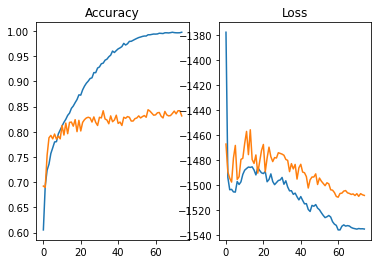

In [43]:
plt.subplot(1, 2, 1)
plt.plot(list(range(nb_epochs)), train_accs, label="Train")
plt.plot(list(range(nb_epochs)), val_accs, label="Val")
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(list(range(nb_epochs)), train_losses, label="Train")
plt.plot(list(range(nb_epochs)), val_losses, label="Val")
plt.title("Loss")

### Testing

In [44]:
state_dict = torch.load("vggpal_best_param.pth")
vggpal.load_state_dict(state_dict)

<All keys matched successfully>

In [54]:
test_acc, test_loss = eval_modelpal(vggpal, test_loader)
test_acc, test_loss

(0.8327668252889191, -1518.735863727072)